In [1]:
import boto3
import pandas as pd
import numpy as np
import re
from io import StringIO
import datetime
from dotenv import load_dotenv
import os


In [2]:
# Nazwa bucketu S3
BUCKET_NAME = "zadmod-9"

# Wczytanie zmiennych środowiskowych
load_dotenv()

# Inicjalizacja klienta S3
s3 = boto3.client("s3")

def load_data_from_s3(file_key):
    """Wczytuje dane z S3 do DataFrame."""
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)
    csv_data = obj['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_data), sep=";")
    return df

# Wczytywanie danych dla 2023 i 2024
wroclaw_2023_df = load_data_from_s3("Dane_mod9/halfmarathon_wroclaw_2023__final.csv")
wroclaw_2024_df = load_data_from_s3("Dane_mod9/halfmarathon_wroclaw_2024__final.csv")


In [3]:
# I. KONWERSJA CZASU
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']: #DID NOT START / DID NOT FINISH
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])


In [4]:
# Usuwanie zbędnych kolumn
def get_cleaned_dataframe(df_2023: pd.DataFrame, df_2024: pd.DataFrame) -> pd.DataFrame:
    df_combined = pd.concat([df_2023, df_2024], ignore_index=True)  # Łączenie danych z obu lat
    df_model = df_combined[df_combined['Miejsce'].notnull()].copy() # Usuwanie wierszy z brakującymi miejscami 

    # Usuwanie zbędnych kolumn
    columns_to_drop = ['Drużyna', 'Miasto'] # Wybrane kolumny do usunięcia
    df_model.drop(columns=columns_to_drop, inplace=True)

    return df_model


In [5]:
cleaned_df = get_cleaned_dataframe(wroclaw_2023_df, wroclaw_2024_df)
missing_values_count = cleaned_df.isna().sum().reset_index(name='ilość')


In [6]:
cleaned_df.isna().sum().reset_index(name='ilość')


,index,ilość
0,Miejsce,0
1,Numer startowy,0
2,Imię,0
3,Nazwisko,0
4,Kraj,0
5,Płeć,0
6,Płeć Miejsce,0
7,Kategoria wiekowa,20
8,Kategoria wiekowa Miejsce,20
9,Rocznik,485


In [7]:
# Uzupełnia brakujące wartości w kolumnie 'Rocznik' medianą dla każdej 'Kategorii wiekowej' i dodaje kolumnę 'Wiek
def impute_rocznik_from_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Uzupełnia brakujące wartości w kolumnie 'Rocznik'
    medianą dla każdej 'Kategorii wiekowej' i dodaje kolumnę 'Wiek'.
    """
    if 'Rocznik' not in df.columns or 'Kategoria wiekowa' not in df.columns:
        return df

    df_result = df.copy()

    # Oblicz medianę 'Rocznik' dla każdej kategorii wiekowej
    median_map = df_result.groupby('Kategoria wiekowa')['Rocznik'].transform('median').round(0).astype('Int64')

    # Uzupełnij brakujące 'Rocznik' medianą odpowiedniej kategorii
    df_result['Rocznik'] = df_result['Rocznik'].fillna(median_map)

    # Dodaj kolumnę 'Wiek'
    df_result['Wiek'] = 2024 - df_result['Rocznik']

    # Usuń kolumnę 'Rocznik'
    df_result = df_result.drop(columns=['Rocznik'])

    # Wyświetl liczby brakujących przed i po
    print(f"Brakujące wartości w 'Rocznik' przed imputacją: {(df['Rocznik'].isnull().sum())}")
    print(f"Brakujące wartości w 'Rocznik' po imputacji: {(df_result['Wiek'].isnull().sum())}")

    return df_result


In [8]:
cleaned_df = get_cleaned_dataframe(wroclaw_2023_df, wroclaw_2024_df)
cleaned_df = impute_rocznik_from_category(cleaned_df)
cleaned_df


Brakujące wartości w 'Rocznik' przed imputacją: 485
Brakujące wartości w 'Rocznik' po imputacji: 0


,Miejsce,Numer startowy,Imię,Nazwisko,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,5 km Czas,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
0,1.0,1787,TOMASZ,GRYCKO,POL,M,1.0,M30,1.0,00:14:37,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,32.0
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,POL,M,2.0,M30,2.0,00:14:48,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,38.0
2,3.0,3832,KRZYSZTOF,HADAS,POL,M,3.0,M20,1.0,00:15:46,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,28.0
3,4.0,416,DAMIAN,DYDUCH,POL,M,4.0,M30,3.0,00:16:11,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,36.0
4,5.0,8476,KAMIL,MAŃKOWSKI,POL,M,5.0,M20,2.0,00:16:12,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,10298.0,898,EWA KATARZYNA,KASIERSKA,POL,K,3059.0,K70,6.0,00:43:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03:19:47,9.470649,76.0
19246,10299.0,10456,MAGDALENA,PRYNDA,POL,K,3060.0,K40,1030.0,00:42:06,...,02:15:28,10301.0,9.580000,03:10:19,10303.0,10.970000,0.162733,03:21:08,9.534645,46.0
19247,10300.0,11311,HELENA,KOLANY,POL,K,3061.0,K60,48.0,00:49:20,...,02:23:22,10303.0,9.010000,03:11:34,10304.0,9.640000,-0.029333,03:22:18,9.589950,69.0
19248,10301.0,8404,JOANNA,KAJDANEK,POL,K,3062.0,K40,1031.0,00:46:48,...,02:26:03,10304.0,9.980000,03:17:25,10305.0,10.273333,0.057000,03:28:32,9.885439,43.0


In [9]:
# Zmiana kolumn czasu w cleaned_df - Konwersja czasu na sekundy
time_columns = ['5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas', 'Czas']
cleaned_df[time_columns] = cleaned_df[time_columns].applymap(convert_time_to_seconds)

# Teraz wyświetlasz
print(cleaned_df)


       Miejsce  Numer startowy           Imię       Nazwisko Kraj Płeć  \
0          1.0            1787         TOMASZ         GRYCKO  POL    M   
1          2.0               3      ARKADIUSZ  GARDZIELEWSKI  POL    M   
2          3.0            3832      KRZYSZTOF          HADAS  POL    M   
3          4.0             416         DAMIAN         DYDUCH  POL    M   
4          5.0            8476          KAMIL      MAŃKOWSKI  POL    M   
...        ...             ...            ...            ...  ...  ...   
19245  10298.0             898  EWA KATARZYNA      KASIERSKA  POL    K   
19246  10299.0           10456      MAGDALENA         PRYNDA  POL    K   
19247  10300.0           11311         HELENA         KOLANY  POL    K   
19248  10301.0            8404         JOANNA       KAJDANEK  POL    K   
19249  10302.0           11155      Anonimowy       ZAWODNIK  POL    M   

       Płeć Miejsce Kategoria wiekowa  Kategoria wiekowa Miejsce  5 km Czas  \
0               1.0             

C:\Users\Michal\AppData\Local\Temp\ipykernel_1832\3363593751.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_df[time_columns] = cleaned_df[time_columns].applymap(convert_time_to_seconds)


In [10]:
# Usuwanie brakujących wartości
cleaned_df.dropna(subset=time_columns, inplace=True)
print(f"Liczba rekordów po usunięciu brakujących: {len(cleaned_df)}")


Liczba rekordów po usunięciu brakujących: 18377


In [11]:
cleaned_df.isna().sum().reset_index(name='ilość')


,index,ilość
0,Miejsce,0
1,Numer startowy,0
2,Imię,0
3,Nazwisko,0
4,Kraj,0
5,Płeć,0
6,Płeć Miejsce,0
7,Kategoria wiekowa,17
8,Kategoria wiekowa Miejsce,17
9,5 km Czas,0


In [12]:
# Usuwanie outliers

# Funkcja do policzenia liczby outliers w serii
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

# Funkcja do usuwania outliers z DataFrame w podanej kolumnie
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()

# Lista kolumn, z których chcesz usunąć outliers
columns_to_clean = [
    'Tempo', 
    '5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas', 'Czas',
    '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo'
]

# Liczba outliers przed usunięciem
outliers_counts = {}
for col in columns_to_clean:
    if col in cleaned_df.columns and pd.api.types.is_numeric_dtype(cleaned_df[col]):
        outliers_counts[col] = count_outliers(cleaned_df[col])

print("--- Liczba outliers przed usunięciem ---")
for col, count in outliers_counts.items():
    print(f"{col}: {count}")

# Usuwanie outliers kaskadowo
for col in columns_to_clean:
    if col in cleaned_df.columns and pd.api.types.is_numeric_dtype(cleaned_df[col]):
        cleaned_df = remove_outliers(cleaned_df, col)

print(f"\nLiczba rekordów po usunięciu outliers: {len(cleaned_df)}")


--- Liczba outliers przed usunięciem ---
Tempo: 222
5 km Czas: 135
10 km Czas: 178
15 km Czas: 203
20 km Czas: 225
Czas: 222
5 km Tempo: 135
10 km Tempo: 256
15 km Tempo: 294
20 km Tempo: 408

Liczba rekordów po usunięciu outliers: 17626


In [13]:
# CECHY INTERAKCYJNE: CZAS × WIEK × PŁEĆ

print("\n" + "="*60)
print("TWORZENIE CECH INTERAKCYJNYCH (CZAS 5KM × WIEK × PŁEĆ)")
print("="*60)

# 1. Normalizacja czasu 5km (z-score) - ułatwia modelowi uczenie się
mean_5km = cleaned_df['5 km Czas'].mean()
std_5km = cleaned_df['5 km Czas'].std()
cleaned_df['czas_5km_normalized'] = (cleaned_df['5 km Czas'] - mean_5km) / std_5km

# 2. Normalizacja wieku (z-score)
mean_wiek = cleaned_df['Wiek'].mean()
std_wiek = cleaned_df['Wiek'].std()
cleaned_df['wiek_normalized'] = (cleaned_df['Wiek'] - mean_wiek) / std_wiek

# 3. Zmienna binarna dla płci (1 = Mężczyzna, 0 = Kobieta)
cleaned_df['is_male'] = (cleaned_df['Płeć'] == 'M').astype(int)

# 4. CECHY INTERAKCYJNE - kluczowe dla uwzględnienia wieku i płci!

# Czas 5km × Wiek - starsi biegacze z tym samym czasem mogą mieć inny czas końcowy
cleaned_df['czas5km_x_wiek'] = cleaned_df['czas_5km_normalized'] * cleaned_df['wiek_normalized']

# Czas 5km × Płeć (Mężczyźni) - mężczyźni mogą inaczej reagować na czas 5km
cleaned_df['czas5km_x_male'] = cleaned_df['czas_5km_normalized'] * cleaned_df['is_male']

# Czas 5km × Płeć (Kobiety)
cleaned_df['czas5km_x_female'] = cleaned_df['czas_5km_normalized'] * (1 - cleaned_df['is_male'])

# Wiek × Płeć - różnice biologiczne między płciami w różnym wieku
cleaned_df['wiek_x_male'] = cleaned_df['wiek_normalized'] * cleaned_df['is_male']

# Czas 5km × Wiek × Płeć - potrójna interakcja (najważniejsza!)
cleaned_df['czas5km_x_wiek_x_male'] = cleaned_df['czas_5km_normalized'] * cleaned_df['wiek_normalized'] * cleaned_df['is_male']

# Cechy nieliniowe
cleaned_df['czas_5km_squared'] = cleaned_df['czas_5km_normalized'] ** 2
cleaned_df['wiek_squared'] = cleaned_df['wiek_normalized'] ** 2

# Interakcje z cechami kwadratowymi
cleaned_df['czas5km_sq_x_wiek'] = cleaned_df['czas_5km_squared'] * cleaned_df['wiek_normalized']
cleaned_df['czas5km_x_wiek_sq'] = cleaned_df['czas_5km_normalized'] * cleaned_df['wiek_squared']

print("\nUtworzone cechy:")
print("1. czas_5km_normalized - znormalizowany czas 5km")
print("2. wiek_normalized - znormalizowany wiek")
print("3. is_male - czy mężczyzna (0/1)")
print("4. czas5km_x_wiek - interakcja czas × wiek")
print("5. czas5km_x_male - interakcja czas × mężczyzna")
print("6. czas5km_x_female - interakcja czas × kobieta")
print("7. wiek_x_male - interakcja wiek × mężczyzna")
print("8. czas5km_x_wiek_x_male - potrójna interakcja czas × wiek × płeć")
print("9. czas_5km_squared - czas 5km do kwadratu")
print("10. wiek_squared - wiek do kwadratu")
print("11. czas5km_sq_x_wiek - czas² × wiek")
print("12. czas5km_x_wiek_sq - czas × wiek²")

print("\nPrzykładowe wartości cech:")
print(cleaned_df[['5 km Czas', 'Wiek', 'Płeć', 'czas5km_x_wiek', 
                   'czas5km_x_male', 'czas5km_x_wiek_x_male']].head(10))

# Zapisz statystyki normalizacji (będą potrzebne do predykcji)
print(f"\nStatystyki do zapisania:")
print(f"mean_5km = {mean_5km}")
print(f"std_5km = {std_5km}")
print(f"mean_wiek = {mean_wiek}")
print(f"std_wiek = {std_wiek}")



TWORZENIE CECH INTERAKCYJNYCH (CZAS 5KM × WIEK × PŁEĆ)

Utworzone cechy:
1. czas_5km_normalized - znormalizowany czas 5km
2. wiek_normalized - znormalizowany wiek
3. is_male - czy mężczyzna (0/1)
4. czas5km_x_wiek - interakcja czas × wiek
5. czas5km_x_male - interakcja czas × mężczyzna
6. czas5km_x_female - interakcja czas × kobieta
7. wiek_x_male - interakcja wiek × mężczyzna
8. czas5km_x_wiek_x_male - potrójna interakcja czas × wiek × płeć
9. czas_5km_squared - czas 5km do kwadratu
10. wiek_squared - wiek do kwadratu
11. czas5km_sq_x_wiek - czas² × wiek
12. czas5km_x_wiek_sq - czas × wiek²

Przykładowe wartości cech:
    5 km Czas  Wiek Płeć  czas5km_x_wiek  czas5km_x_male  \
8      1030.0  23.0    M        0.879488       -2.764937   
10     1029.0  27.0    M        0.685906       -2.769339   
11     1035.0  32.0    M        0.437961       -2.742928   
12     1035.0  28.0    M        0.631084       -2.742928   
13     1036.0  33.0    M        0.389055       -2.738527   
14     1038.

In [14]:
cleaned_df


,Miejsce,Numer startowy,Imię,Nazwisko,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,5 km Czas,...,is_male,czas5km_x_wiek,czas5km_x_male,czas5km_x_female,wiek_x_male,czas5km_x_wiek_x_male,czas_5km_squared,wiek_squared,czas5km_sq_x_wiek,czas5km_x_wiek_sq
8,9.0,5657,CYPRIAN,GRZELKA,POL,M,9.0,M20,4.0,1030.0,...,1,0.879488,-2.764937,-0.000000,-0.318086,0.879488,7.644878,0.101179,-2.43173,-0.279753
10,11.0,7270,MATEUSZ,POŁCZYŃSKI,POL,M,11.0,M20,5.0,1029.0,...,1,0.685906,-2.769339,-0.000000,-0.247679,0.685906,7.669239,0.061345,-1.899507,-0.169884
11,12.0,4367,MACIEJ,KARDAS,POL,M,12.0,M30,6.0,1035.0,...,1,0.437961,-2.742928,-0.000000,-0.159669,0.437961,7.523656,0.025494,-1.201296,-0.069929
12,13.0,923,SEBASTIAN,CIEŚLA,POL,M,13.0,M20,6.0,1035.0,...,1,0.631084,-2.742928,-0.000000,-0.230077,0.631084,7.523656,0.052935,-1.731018,-0.145198
13,14.0,4565,WOJCIECH,DURCZYŃSKI,POL,M,14.0,M30,7.0,1036.0,...,1,0.389055,-2.738527,-0.000000,-0.142067,0.389055,7.499527,0.020183,-1.065438,-0.055272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18999,10052.0,3158,PRZEMYSŁAW,STELMACH,POL,M,7129.0,M40,2360.0,2219.0,...,1,-0.003092,2.468793,0.000000,-0.001252,-0.003092,6.094937,0.000002,-0.007633,0.000004
19000,10053.0,1987,PAWEŁ,NOWICKI,POL,M,7130.0,M40,2361.0,2220.0,...,1,-0.003097,2.473194,0.000000,-0.001252,-0.003097,6.116690,0.000002,-0.00766,0.000004
19003,10056.0,11600,KATARZYNA,KOPROWSKA,POL,K,2925.0,K30,1013.0,2289.0,...,0,-0.150114,0.000000,2.776918,-0.0,-0.0,7.711273,0.002922,-0.416856,0.008115
19008,10061.0,9801,IWONA,HOŁOWACZ,POL,K,2928.0,K40,990.0,2146.0,...,0,0.299706,0.000000,2.147462,0.0,0.0,4.611592,0.019478,0.643607,0.041828


In [15]:
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, predict_model


In [16]:
# Eksperymwnt na całymm zbiorze z zmienną docelową 'Czas'
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 49)"
5,Transformed train set shape,"(12338, 49)"
6,Transformed test set shape,"(5288, 49)"
7,Numeric features,31
8,Categorical features,5
9,Rows with missing values,0.1%


In [17]:
# Trenuje i ocenia wszystkie modele za pomocą walidacji krzyżowej (domyślnie 10-krotnej).
best_model_v1 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0001,0.0000,0.0002,1.0000,0.0000,0.0000,0.5290
rf,Random Forest Regressor,0.4670,5.6751,1.8813,1.0000,0.0003,0.0001,2.2740
dt,Decision Tree Regressor,0.7685,9.9227,2.7399,1.0000,0.0004,0.0001,0.1080
et,Extra Trees Regressor,1.0126,15.9208,3.5728,1.0000,0.0005,0.0001,1.0290
ridge,Ridge Regression,3.7054,24.1914,4.9116,1.0000,0.0007,0.0005,0.0780
lightgbm,Light Gradient Boosting Machine,4.9261,71.9003,8.3779,0.9999,0.0012,0.0007,0.2480
gbr,Gradient Boosting Regressor,7.8360,111.1644,10.5335,0.9999,0.0015,0.0011,1.0660
llar,Lasso Least Angle Regression,17.9127,560.9832,23.6604,0.9995,0.0032,0.0025,0.0780
en,Elastic Net,19.4847,630.9890,25.1072,0.9995,0.0034,0.0027,0.1800
lasso,Lasso Regression,20.4133,713.3117,26.6951,0.9994,0.0036,0.0028,0.4030


In [18]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo'],
    keep_features=['20 km Czas', '15 km Czas', '10 km Czas', '5 km Czas','Wiek','Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 32)"
5,Transformed train set shape,"(12338, 32)"
6,Transformed test set shape,"(5288, 32)"
7,Ignore features,5
8,Numeric features,25
9,Categorical features,1


In [19]:
best_model_v2 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,12.3749,378.0717,19.3628,0.9997,0.0025,0.0017,0.1900
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0370


In [20]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo','5 km Czas','10 km Czas','15 km Czas','20 km Czas'],
    keep_features=['Wiek', 'Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 28)"
5,Transformed train set shape,"(12338, 28)"
6,Transformed test set shape,"(5288, 28)"
7,Ignore features,9
8,Numeric features,21
9,Categorical features,1


In [21]:
best_model_v3 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,27.3953,1542.6996,39.2245,0.9987,0.0051,0.0037,0.1750
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0320


In [22]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem, oraz sprawdzam różne dystanse czasu
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo','10 km Czas','15 km Czas', '20 km Czas'],
    keep_features=['5 km Czas','Wiek','Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 29)"
5,Transformed train set shape,"(12338, 29)"
6,Transformed test set shape,"(5288, 29)"
7,Ignore features,8
8,Numeric features,22
9,Categorical features,1


In [23]:

best_model_v4 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,27.5243,1539.8433,39.2065,0.9987,0.0051,0.0037,0.1820
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0330


In [24]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem, oraz sprawdzam różne dystansy czasu
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo', '5 km Czas', '15 km Czas', '20 km Czas'],
    keep_features=['10 km Czas','Wiek','Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 29)"
5,Transformed train set shape,"(12338, 29)"
6,Transformed test set shape,"(5288, 29)"
7,Ignore features,8
8,Numeric features,22
9,Categorical features,1


In [25]:
best_model_v5 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,21.5037,971.5659,31.1378,0.9992,0.0040,0.0029,0.1870
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0340


In [26]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem, oraz sprawdzam różne dystanse czasu
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo', '5 km Czas', '10 km Czas', '20 km Czas'],
    keep_features=['15 km Czas', 'Wiek','Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 29)"
5,Transformed train set shape,"(12338, 29)"
6,Transformed test set shape,"(5288, 29)"
7,Ignore features,8
8,Numeric features,22
9,Categorical features,1


In [27]:
best_model_v6 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,23.1334,1053.6645,32.4109,0.9991,0.0042,0.0031,0.1970
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0360


Wybieram najlepszy model z najmniejszym błędem

In [28]:
# Ignoruje kolumny z tempem, ponieważ nie mają ścisłe powiązanie z czasem, oraz sprawdzam różne dystanse czasu
exp = setup(
    data=cleaned_df,
    target='Czas', # Czas ukończenia biegu w sekundach jako zmienna docelowa
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo', '20 km Czas'],
    keep_features=['5 km Czas', '10 km Czas', '15 km Czas', 'Wiek','Płeć'],
    categorical_features=['Wiek'],
    session_id=123,
    verbose=True,
    
)
# exp.dataset_transformed.sample(10)


,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 31)"
5,Transformed train set shape,"(12338, 31)"
6,Transformed test set shape,"(5288, 31)"
7,Ignore features,6
8,Numeric features,24
9,Categorical features,1


In [29]:
best_model_v7 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,22.5101,1006.9870,31.6830,0.9991,0.0041,0.0030,0.1890
dummy,Dummy Regressor,870.0064,1158167.7093,1075.9946,-0.0012,0.1494,0.1230,0.0360


In [30]:
# Eksperyment z cechami interakcyjnymi (bez tempa!)
exp = setup(
    data=cleaned_df,
    target='Czas',
    ignore_features=['Tempo', '5 km Tempo', '10 km Tempo', '15 km Tempo', '20 km Tempo',
                     '10 km Czas', '15 km Czas', '20 km Czas',
                     'Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Kraj',
                     'Płeć Miejsce', 'Kategoria wiekowa', 'Kategoria wiekowa Miejsce',
                     '5 km Miejsce Open', '10 km Miejsce Open', '15 km Miejsce Open', 
                     '20 km Miejsce Open', 'Tempo Stabilność',
                     'Płeć'],  # Płeć jest zignorowana, ponieważ cecha is_male jest 0/1
    keep_features=['5 km Czas', 'czas_5km_normalized', 'Wiek', 'wiek_normalized', 'is_male',
                   'czas5km_x_wiek', 'czas5km_x_male', 'czas5km_x_female', 'wiek_x_male',
                   'czas5km_x_wiek_x_male', 'czas_5km_squared', 'wiek_squared',
                   'czas5km_sq_x_wiek', 'czas5km_x_wiek_sq'],
    session_id=123,
    verbose=True,
)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17626, 37)"
4,Transformed data shape,"(17626, 15)"
5,Transformed train set shape,"(12338, 15)"
6,Transformed test set shape,"(5288, 15)"
7,Ignore features,22
8,Numeric features,14
9,Keep features,14


In [31]:
best_model_v8 = exp.compare_models(sort='MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,267.5574,132453.3867,363.7915,0.8854,0.0477,0.0356,0.0840
lasso,Lasso Regression,271.1370,129835.3842,360.2022,0.8877,0.0474,0.0364,0.0190
llar,Lasso Least Angle Regression,271.1378,129833.8971,360.2001,0.8877,0.0474,0.0364,0.0160
br,Bayesian Ridge,271.2048,129852.4941,360.2255,0.8877,0.0474,0.0364,0.0200
ridge,Ridge Regression,271.2949,129941.0770,360.3490,0.8876,0.0474,0.0364,0.0170
lr,Linear Regression,271.3168,129957.9983,360.3724,0.8876,0.0474,0.0364,0.0200
en,Elastic Net,271.6636,130298.8706,360.8388,0.8873,0.0475,0.0364,0.0200
omp,Orthogonal Matching Pursuit,272.2387,130964.5106,361.7460,0.8867,0.0475,0.0365,0.0160
gbr,Gradient Boosting Regressor,272.2756,130809.8817,361.5565,0.8868,0.0476,0.0365,0.3440
lightgbm,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1080


In [32]:
best_model = compare_models([best_model_v1, best_model_v2, best_model_v3, best_model_v4, best_model_v5, best_model_v6, best_model_v7, best_model_v8])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Linear Regression,271.3168,129957.9983,360.3724,0.8876,0.0474,0.0364,0.0170
7,Huber Regressor,267.5574,132453.3867,363.7915,0.8854,0.0477,0.0356,0.0860
1,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1050
2,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1140
3,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1090
4,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1080
5,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1100
6,Light Gradient Boosting Machine,275.9824,134802.1960,367.0387,0.8834,0.0482,0.0370,0.1010


In [33]:
# Strojenie hiperparametrów
best_model_tuned = exp.tune_model(
    estimator=best_model,  # Wybrany model
    n_iter=50,            # Liczba iteracji dla Random Grid Search
    optimize='MAE'         # Metryka do optymalizacji
)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,259.1802,114980.2425,339.0874,0.8980,0.0448,0.0350
1,269.4136,130838.1984,361.7156,0.8868,0.0473,0.0362
2,276.0040,133488.0328,365.3601,0.8788,0.0483,0.0371
3,269.2323,125738.7792,354.5966,0.8833,0.0465,0.0360
4,282.4105,141136.8870,375.6819,0.8836,0.0496,0.0379
5,270.0840,133124.2398,364.8619,0.8843,0.0478,0.0362
6,275.2799,136542.3715,369.5164,0.8842,0.0482,0.0364
7,266.3889,125836.9109,354.7350,0.8922,0.0467,0.0357
8,272.9724,130649.6212,361.4549,0.8926,0.0476,0.0365


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
best_final_model = compare_models([best_model, best_model_tuned])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Linear Regression,271.3168,129957.9983,360.3724,0.8876,0.0474,0.0364,0.0190
1,Linear Regression,271.3168,129957.9983,360.3724,0.8876,0.0474,0.0364,0.0160


## Porównanie oryginalnego modelu, oraz modelu po strojeniu hiperparametrów

In [35]:
exp.predict_model(best_final_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,276.8855,133824.5078,365.8203,0.8842,0.0480,0.0370


,5 km Czas,Wiek,czas_5km_normalized,wiek_normalized,is_male,czas5km_x_wiek,czas5km_x_male,czas5km_x_female,wiek_x_male,czas5km_x_wiek_x_male,czas_5km_squared,wiek_squared,czas5km_sq_x_wiek,czas5km_x_wiek_sq,Czas,prediction_label
6248,1979.0,26.0,1.412363,-0.265281,1,-0.374672,1.412363,0.000000,-0.265281,-0.374672,1.994768,0.070374,-0.529173,0.099393,8158,8615.991171
12308,1641.0,44.0,-0.075443,0.051553,1,-0.003889,-0.075443,-0.000000,0.051553,-0.003889,0.005692,0.002658,0.000293,-0.000201,6859,7229.319682
7665,2120.0,24.0,2.033015,-0.300484,0,-0.610889,0.000000,2.033015,-0.0,-0.0,4.133151,0.090291,-1.241947,0.183563,9419,9236.443819
7379,1882.0,29.0,0.985389,-0.212475,0,-0.20937,0.000000,0.985389,-0.0,-0.0,0.970991,0.045146,-0.206311,0.044486,9082,8258.171739
18655,2129.0,33.0,2.072631,-0.142067,0,-0.294453,0.000000,2.072631,-0.0,-0.0,4.295801,0.020183,-0.610293,0.041832,9574,9338.561775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,1618.0,31.0,-0.176684,-0.177271,1,0.031321,-0.176684,-0.000000,-0.177271,0.031321,0.031217,0.031425,-0.005534,-0.005552,6747,7105.259158
795,1385.0,33.0,-1.202301,-0.142067,1,0.170808,-1.202301,-0.000000,-0.142067,0.170808,1.445529,0.020183,-0.205362,-0.024266,5906,6084.068086
17509,1926.0,41.0,1.179068,-0.001252,1,-0.001477,1.179068,0.000000,-0.001252,-0.001477,1.390201,0.000002,-0.001741,0.000002,8607,8475.810943
786,1314.0,37.0,-1.514829,-0.07166,1,0.108552,-1.514829,-0.000000,-0.07166,0.108552,2.294706,0.005135,-0.164438,-0.007779,5902,5759.519368


Podgląd predykcji pozwala zrozumieć, co model przewidywał i na podstawie jakich danych:

Cel Predykcji: Zmienna docelowa to prediction_label. Biorąc pod uwagę inne kolumny (5 km Czas Open, 10 km Czas Open, etc.), można ztwierdzić że model przewiduje czas biegu (np. półmaratonu/maratonu).

Kluczowe Predyktory: Model wykorzystuje szereg cech związanych z bieganiem, takich jak:

Czasy na krótszych dystansach (5 km Czas Open, 10 km Czas Open, 15 km Czas Open).

Płeć, Kategoria wiekowa (M20, K20, M30).

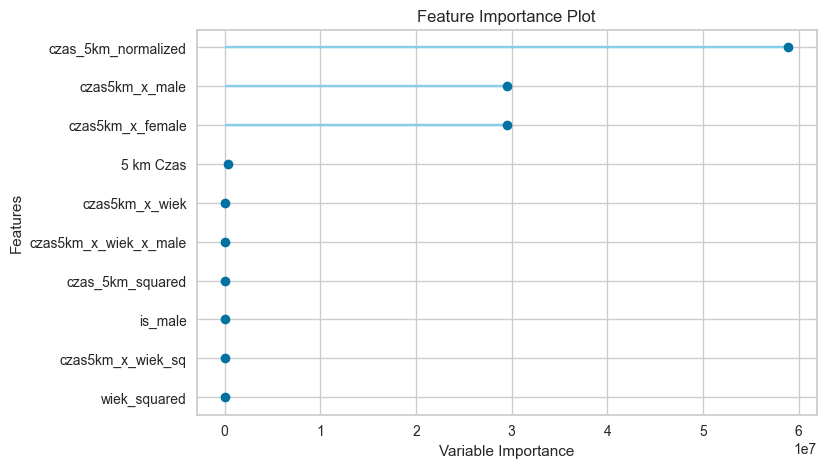

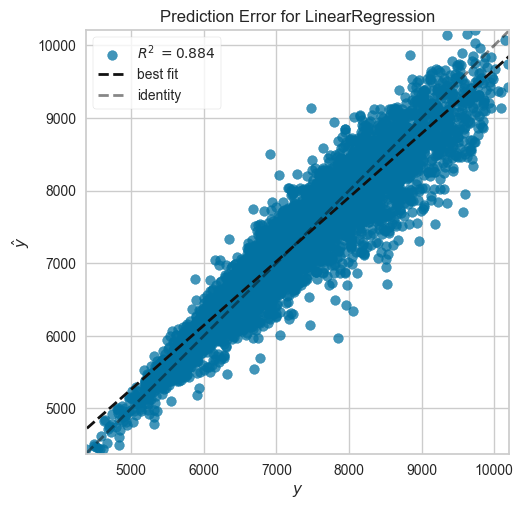

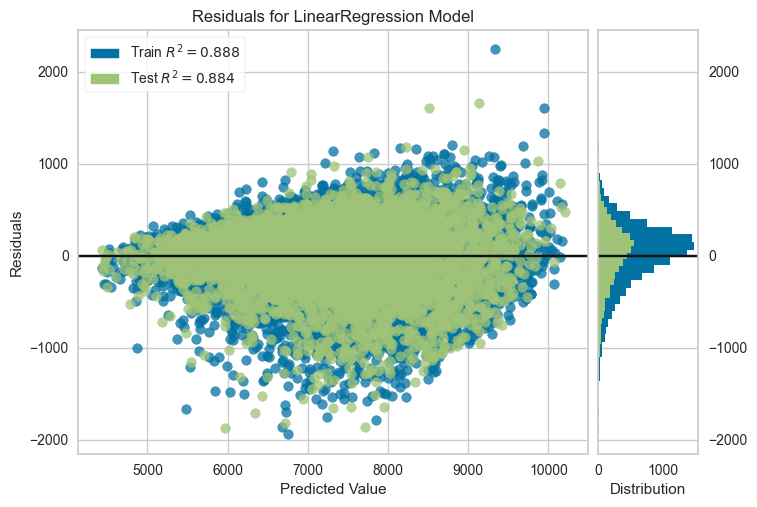

In [36]:
plot_model(best_final_model, plot='feature')
plot_model(best_final_model, plot='error')
plot_model(best_final_model, plot='residuals')


In [37]:
# Trenowanie modelu na całym zbiorze danych
final_model = finalize_model(best_final_model)


In [38]:
# Zapis modelu lokalnie
final_model = finalize_model(best_model)
save_model(final_model, 'final_regression_pipeline')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas', 'Wiek',
                                              'czas_5km_normalized',
                                              'wiek_normalized', 'is_male',
                                              'czas5km_x_wiek', 'czas5km_x_male',
                                              'czas5km_x_female', 'wiek_x_male',
                                              'czas5km_x_wiek_x_male',
                                              'czas_5km_squared', 'wiek_squared',
                                              'czas5km_sq_x_wiek',
                                              'czas5km_x_wiek_sq'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
        

In [39]:
s3.upload_file(
    Filename='final_regression_pipeline.pkl',
    Bucket=BUCKET_NAME,
    Key='Train_Model/final_regression_pipeline.pkl'
)


In [40]:
def predict_halfmarathon_time(wiek, plec, five_k_time_sec, model):
    """
    Funkcja do predykcji czasu ukończenia półmaratonu.

    Args:
        wiek (int): wiek biegacza
        plec (str): 'M' lub 'K'
        five_k_time_sec (int): czas 5 km w sekundach
        model: wytrenowany model pycaret

    Returns:
        str: czas w formacie H:M:S
    """
    # Dane wejściowe z wszystkimi kolumnami
    user_input = pd.DataFrame([{
        'Miejsce': 1.0,
        'Numer startowy': 1,
        'Imię': 'Test',
        'Nazwisko': 'User',
        'Kraj': 'POL',
        'Płeć': plec,
        'Płeć Miejsce': 1.0,
        'Kategoria wiekowa': 'M30' if plec == 'M' else 'K30',
        'Kategoria wiekowa Miejsce': 1.0,
        '5 km Czas': five_k_time_sec,
        '5 km Miejsce Open': 1.0,
        '10 km Czas': five_k_time_sec * 2,  # Przybliżenie
        '10 km Miejsce Open': 1.0,
        '15 km Czas': five_k_time_sec * 3,  # Przybliżenie
        '15 km Miejsce Open': 1.0,
        '20 km Czas': five_k_time_sec * 4,  # Przybliżenie
        '20 km Miejsce Open': 1.0,
        'Tempo Stabilność': 0.02,
        'Wiek': wiek
    }])

    # Tworzenie cech interakcyjnych (muszą być tworzone tak samo jak w treningu)
    # Normalizacja czasu 5km
    user_input['czas_5km_normalized'] = (user_input['5 km Czas'] - mean_5km) / std_5km
    
    # Normalizacja wieku
    user_input['wiek_normalized'] = (user_input['Wiek'] - mean_wiek) / std_wiek
    
    # Zmienna binarna dla płci
    user_input['is_male'] = (user_input['Płeć'] == 'M').astype(int)
    
    # Cechy interakcyjne
    user_input['czas5km_x_wiek'] = user_input['czas_5km_normalized'] * user_input['wiek_normalized']
    user_input['czas5km_x_male'] = user_input['czas_5km_normalized'] * user_input['is_male']
    user_input['czas5km_x_female'] = user_input['czas_5km_normalized'] * (1 - user_input['is_male'])
    user_input['wiek_x_male'] = user_input['wiek_normalized'] * user_input['is_male']
    user_input['czas5km_x_wiek_x_male'] = user_input['czas_5km_normalized'] * user_input['wiek_normalized'] * user_input['is_male']
    
    # Cechy nieliniowe
    user_input['czas_5km_squared'] = user_input['czas_5km_normalized'] ** 2
    user_input['wiek_squared'] = user_input['wiek_normalized'] ** 2
    
    # Interakcje z cechami kwadratowymi
    user_input['czas5km_sq_x_wiek'] = user_input['czas_5km_squared'] * user_input['wiek_normalized']
    user_input['czas5km_x_wiek_sq'] = user_input['czas_5km_normalized'] * user_input['wiek_squared']

    # Predykcja
    prediction = predict_model(model, data=user_input)
    pred_seconds = int(round(prediction['prediction_label'][0]))

    # Konwersja na H:M:S
    pred_time_str = str(datetime.timedelta(seconds=pred_seconds))
    return pred_time_str

# Przykład użycia:
wiek_input = 42
plec_input = 'M'
czas_5km_input = 2000  # w sekundach

predykcja_czasu = predict_halfmarathon_time(wiek_input, plec_input, czas_5km_input, final_model)
print(f"Przewidywany czas ukończenia półmaratonu: {predykcja_czasu}")



Przewidywany czas ukończenia półmaratonu: 2:26:44


In [41]:
# Zapisz statystyki normalizacji
normalization_stats = {
    'mean_5km': float(mean_5km),
    'std_5km': float(std_5km),
    'mean_wiek': float(mean_wiek),
    'std_wiek': float(std_wiek)
}

import json

# Zapisz lokalnie
with open('normalization_stats.json', 'w') as f:
    json.dump(normalization_stats, f, indent=4)

print("✓ Statystyki normalizacji zapisane lokalnie")

# Prześlij do S3
try:
    s3.upload_file(
        Filename='normalization_stats.json',
        Bucket=BUCKET_NAME,
        Key='Train_Model/normalization_stats.json'
    )
    print("✓ Statystyki normalizacji przesłane do S3")
except Exception as e:
    print(f"❌ Błąd przesyłania statystyk do S3: {e}")



✓ Statystyki normalizacji zapisane lokalnie
✓ Statystyki normalizacji przesłane do S3
